# Capstone Project - The Battle of Neighbourhoods
## Smart Living Sydney Migration Agent - Providing Housing Services

#### Loading Python libraries required to run code

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install lxml
import lxml
!pip install html5lib
import html5lib

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Matplotlib for bar chart
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 5.8MB 1.8MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         237 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0        conda-forge


### Loading Sydney suburbs data from internet website

In [2]:
sydney_df = pd.read_html('https://www.intosydneydirectory.com.au/sydney-postcodes.php')[1]
sydney_df.head()

,0,1,2
0,Abbotsbury,NSW,2176
1,Abbotsford,NSW,2046
2,Agnes Banks,NSW,2753
3,Airds,NSW,2560
4,Alexandria,NSW,2015


### Cleaning up Data

In [3]:
# Rename the columns of our dataframe 
sydney_df.rename(columns={0:"Suburb",1:"State",2:"Postcode"}, inplace=True)
sydney_df.head()

,Suburb,State,Postcode
0,Abbotsbury,NSW,2176
1,Abbotsford,NSW,2046
2,Agnes Banks,NSW,2753
3,Airds,NSW,2560
4,Alexandria,NSW,2015


In [4]:
# Display number of suburbs
sydney_df.shape

(689, 3)

In [5]:
# Check if all suburbs are unique and there is no duplicate
suburb_num = len(sydney_df["Suburb"].unique())
suburb_num

689

##### Since the number of rows are same as the unique number of suburbs, we can conclude that there is no duplicate suburb in the list

In [6]:
print('Sydney has {} suburbs'.format(suburb_num))

Sydney has 689 suburbs


##### As the state column has the value 'NSW', this column is redundant and it will be discarded

In [7]:
# Drop the column "State"
sydney_df.drop("State",axis=1,inplace=True)
sydney_df.head()

,Suburb,Postcode
0,Abbotsbury,2176
1,Abbotsford,2046
2,Agnes Banks,2753
3,Airds,2560
4,Alexandria,2015


In [8]:
sydney_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 2 columns):
Suburb      689 non-null object
Postcode    689 non-null int64
dtypes: int64(1), object(1)
memory usage: 10.9+ KB


#### Formatting the data to include Longitute and Latitude information in order to use FourSquare

##### Add columns Longitude and Latitude to the data frame

In [9]:
sydney_df["Latitude"] = 0
sydney_df["Longitude"] = 0
sydney_df.head()

,Suburb,Postcode,Latitude,Longitude
0,Abbotsbury,2176,0,0
1,Abbotsford,2046,0,0
2,Agnes Banks,2753,0,0
3,Airds,2560,0,0
4,Alexandria,2015,0,0


In [10]:
# Define a function to retrieve longitude and latitude value and fill value of the two coloumns
state = ', NSW'
def get_location(suburb_name):
    address = suburb_name + state
    geolocator = Nominatim(user_agent="sydney_explorer")
    try: # this is to handle suburb which geolocator has failed to return location
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = 0
        longitude = 0
    return pd.Series([latitude, longitude])
#
sydney_df[["Latitude","Longitude"]]=sydney_df.apply(lambda row: get_location(row.Suburb), axis=1)
sydney_df.head()

,Suburb,Postcode,Latitude,Longitude
0,Abbotsbury,2176,-33.869285,150.866703
1,Abbotsford,2046,-33.850553,151.129759
2,Agnes Banks,2753,-33.614508,150.711448
3,Airds,2560,-34.090000,150.826111
4,Alexandria,2015,-33.909157,151.192128


In [12]:
sydney_df.tail(10)

,Suburb,Postcode,Latitude,Longitude
679,Woronora,2232,-34.116496,150.952280
680,Woronora Heights,2233,-34.034387,151.027167
681,Yagoona,2199,-33.903791,151.017668
682,Yanderra,2574,-34.320992,150.572483
683,Yarramundi,2753,-31.234753,148.467871
684,Yarrawarrah,2233,-34.056681,151.030888
685,Yellow Rock,2777,-33.686149,150.642478
686,Yennora,2161,-33.862008,150.968610
687,Yowie Bay,2228,-34.050278,151.103333
688,Zetland,2017,-33.907662,151.208218


##### Check if there is any suburb has no location and drop the suburb 

In [13]:
sydney_null = sydney_df[sydney_df["Latitude"]==0]
sydney_null

,Suburb,Postcode,Latitude,Longitude
601,Sydney Domestic Airport,2020,0.0,0.0
602,Sydney International Airport,2020,0.0,0.0


##### Drop the rows without location information

In [14]:
sydney_df.drop(sydney_df.index[[601,602]],axis=0,inplace=True)
sydney_df.shape

(687, 4)

#### Sydney Suburbs Map

In [15]:
# create map of Sydney using latitude and longitude from our data frame sydney_df
address = 'Sydney, NSW, Australia'
geolocator = Nominatim(user_agent="syd_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=12)

# add neighbourhood markers to map
for lat, lng, suburb in zip(sydney_df['Latitude'], sydney_df['Longitude'], sydney_df['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

### Foursquare: Retrieving venues information for each suburb
#### Define Foursquare Credential and Version and url

In [16]:
CLIENT_ID = 'UXFQU11EG1VECTQDUZJ0OU0FYKEWTYZTVYZBTV2SFRADZ3QD' # My Foursquare ID
CLIENT_SECRET = 'SXAFMA04UVPFHTVWQMLYQ21YTNJZKPG2DOF35SO2LRKE5K44' # My Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UXFQU11EG1VECTQDUZJ0OU0FYKEWTYZTVYZBTV2SFRADZ3QD
CLIENT_SECRET:SXAFMA04UVPFHTVWQMLYQ21YTNJZKPG2DOF35SO2LRKE5K44


#### Define function to get nearby venues for all suburbs

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#       print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print('There is no venue retrieved for suburb {}'.format(name))
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
LIMIT = 100
sydney_venues = getNearbyVenues(names=sydney_df['Suburb'],
                                   latitudes=sydney_df['Latitude'],
                                   longitudes=sydney_df['Longitude']
                                  )
print(sydney_venues.shape)
sydney_venues.head()

(6127, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.869285,150.866703,Abbotsbury Shops,-33.869554,150.865294,Convenience Store
1,Abbotsbury,-33.869285,150.866703,Stockdale Reserve,-33.871098,150.868060,Park
2,Abbotsford,-33.850553,151.129759,The Cove Dining Co,-33.850933,151.129015,Café
3,Abbotsford,-33.850553,151.129759,The Cove Dining Co,-33.850950,151.129110,Café
4,Abbotsford,-33.850553,151.129759,Sistina Ristorante & Pizzeria,-33.848149,151.128307,Pizza Place


In [19]:
# one hot encoding
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb and location column back to dataframe

sydney_onehot['Suburb Latitude'] = sydney_venues['Suburb Latitude']
sydney_onehot['Suburb Longitude'] = sydney_venues['Suburb Longitude']
sydney_onehot['Suburb'] = sydney_venues['Suburb']
# move suburb column to the first column
fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_onehot.head()

,Suburb,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Carpet Store,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Newsstand,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Fie

##### The venues category we are interested are restaurants, grocery shopping and public transport
##### First of all let's search for Indian,Malaysian, Chinese and Italian restaurants and other related venues e.g. Indian stores, indie movie theatre etc.

##### From the sydney_onehot dataframe, we extract venues and create separate dataframe for Indian, Chinese, Malay and Italian venues

In [20]:
sydney_indian = sydney_onehot[["Suburb","Suburb Latitude","Suburb Longitude","Indian Restaurant",
                               "South Indian Restaurant","Indie Movie Theater"]]
sydney_chinese = sydney_onehot[["Suburb","Suburb Latitude","Suburb Longitude", "Chinese Restaurant","Szechuan Restaurant",
                                "Cantonese Restaurant","Dim Sum Restaurant","Dumpling Restaurant","Shanghai Restaurant",
                                "Taiwanese Restaurant"]]
sydney_italian = sydney_onehot[["Suburb","Suburb Latitude","Suburb Longitude","Italian Restaurant"]]
sydney_malay = sydney_onehot[["Suburb","Suburb Latitude","Suburb Longitude", "Malay Restaurant"]]
sydney_transport = sydney_onehot[["Suburb","Airport","Bus Station","Bus Stop","Light Rail Station", "Metro Station","Train Station"]]

#### Let's check Indian venues

In [21]:
sydney_indian.head()

,Suburb,Suburb Latitude,Suburb Longitude,Indian Restaurant,South Indian Restaurant,Indie Movie Theater
0,Abbotsbury,-33.869285,150.866703,0,0,0
1,Abbotsbury,-33.869285,150.866703,0,0,0
2,Abbotsford,-33.850553,151.129759,0,0,0
3,Abbotsford,-33.850553,151.129759,0,0,0
4,Abbotsford,-33.850553,151.129759,0,0,0


##### Drop all suburbs without any Indian venues

In [22]:
syd_indian_venue = sydney_indian[(sydney_indian["Indian Restaurant"]!=0) |
                                 (sydney_indian["South Indian Restaurant"]!=0) |
                                 (sydney_indian["Indie Movie Theater"]!=0)]
syd_indian_venue.head()

,Suburb,Suburb Latitude,Suburb Longitude,Indian Restaurant,South Indian Restaurant,Indie Movie Theater
189,Balgowlah,-33.794442,151.260826,1,0,0
199,Balmain,-33.858399,151.180735,1,0,0
206,Balmain,-33.858399,151.180735,1,0,0
346,Barangaroo,-33.861408,151.201688,1,0,0
650,Bondi,-33.893056,151.263333,1,0,0


In [23]:
syd_indian_venue["Indian Count"] = syd_indian_venue.groupby("Suburb")["Suburb"].transform("count")
syd_indian_venue.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Suburb,Suburb Latitude,Suburb Longitude,Indian Restaurant,South Indian Restaurant,Indie Movie Theater,Indian Count
189,Balgowlah,-33.794442,151.260826,1,0,0,1
199,Balmain,-33.858399,151.180735,1,0,0,2
206,Balmain,-33.858399,151.180735,1,0,0,2
346,Barangaroo,-33.861408,151.201688,1,0,0,1
650,Bondi,-33.893056,151.263333,1,0,0,1


### Top suburbs having Indian venues

In [24]:
top_indian = syd_indian_venue.groupby("Suburb").count()
top_indian_df = top_indian.sort_values(by="Indian Count", ascending=False)
top_indian_df.head(10)

,Suburb Latitude,Suburb Longitude,Indian Restaurant,South Indian Restaurant,Indie Movie Theater,Indian Count
Suburb,,,,,,
Crows Nest,5,5,5,5,5,5
Harris Park,3,3,3,3,3,3
Darlinghurst,3,3,3,3,3,3
North Strathfield,2,2,2,2,2,2
Balmain,2,2,2,2,2,2
Kings Cross,2,2,2,2,2,2
Woolloomooloo,2,2,2,2,2,2
Wentworthville,2,2,2,2,2,2
Waitara,1,1,1,1,1,1


#### Bar Chart of Top 10 Suburbs with Indian venues

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


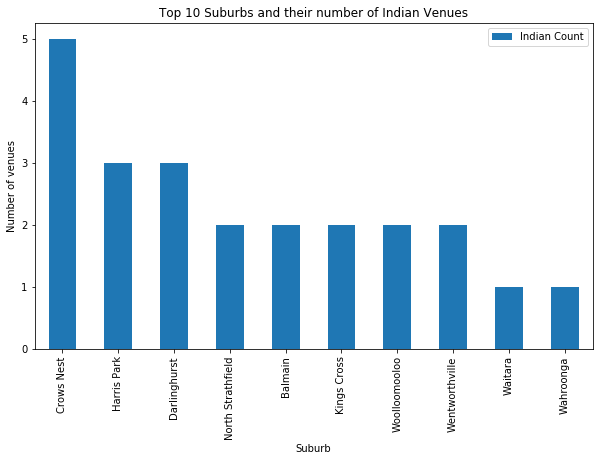

In [30]:
# step 1: get the data
df_indian = top_indian_df.head(10)
df_indian.drop(["Suburb Latitude","Suburb Longitude","Indian Restaurant","South Indian Restaurant",
                "Indie Movie Theater"],axis=1,inplace=True)
# step 2: plot data
df_indian.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Suburb') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Top 10 Suburbs and their number of Indian Venues') # add title to the plot

plt.show()

##### Create a new dataframe with only columns that we are interested

#### Find Italian venues

In [42]:
syd_italian_venue = sydney_italian[(sydney_italian["Italian Restaurant"]!=0)] 
syd_italian_venue.head()

,Suburb,Suburb Latitude,Suburb Longitude,Italian Restaurant
11,Alexandria,-33.909157,151.192128,1
43,Annandale,-33.881224,151.170998,1
203,Balmain,-33.858399,151.180735,1
207,Balmain,-33.858399,151.180735,1
236,Balmain East,-33.857179,151.192354,1


In [43]:
syd_italian_venue["Italian Count"] = syd_italian_venue.groupby("Suburb")["Suburb"].transform('size')
syd_italian_venue.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Suburb,Suburb Latitude,Suburb Longitude,Italian Restaurant,Italian Count
11,Alexandria,-33.909157,151.192128,1,1
43,Annandale,-33.881224,151.170998,1,1
203,Balmain,-33.858399,151.180735,1,2
207,Balmain,-33.858399,151.180735,1,2
236,Balmain East,-33.857179,151.192354,1,1


### Top suburbs having Italian venues

In [44]:
top_italian = syd_italian_venue.groupby("Suburb").count()
top_italian_df =top_italian.sort_values(by="Italian Count", ascending=False)
top_italian_df.head(10)

,Suburb Latitude,Suburb Longitude,Italian Restaurant,Italian Count
Suburb,,,,
Leichhardt,7,7,7,7
Woolloomooloo,7,7,7,7
Kings Cross,7,7,7,7
Rushcutters Bay,6,6,6,6
Darlinghurst,6,6,6,6
Kirribilli,4,4,4,4
Milsons Point,4,4,4,4
Haberfield,4,4,4,4
Elizabeth Bay,4,4,4,4


#### Bar Chart of Top 10 Suburbs with Italian Venues

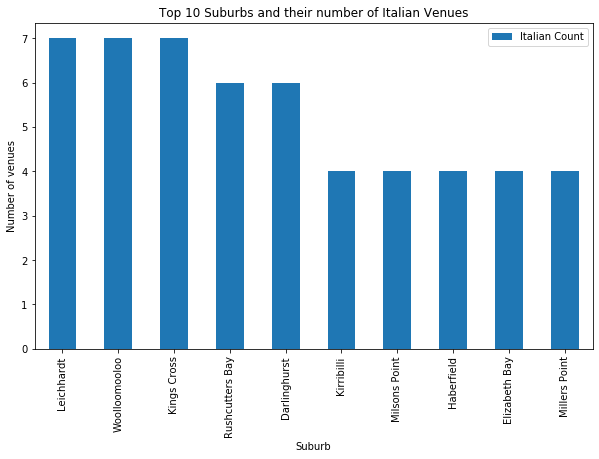

In [45]:
# step 1: get the data
df_italian = top_italian_df.head(10)
df_italian.drop(["Suburb Latitude","Suburb Longitude","Italian Restaurant"],axis=1,inplace=True)
# step 2: plot data
df_italian.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Suburb') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Top 10 Suburbs and their number of Italian Venues') # add title to the plot

plt.show()

#### Find Malay venue

In [46]:
syd_malay_venue = sydney_malay[(sydney_malay["Malay Restaurant"]!=0)] 
syd_malay_venue.head()

,Suburb,Suburb Latitude,Suburb Longitude,Malay Restaurant
127,Ashfield,-33.889478,151.127412,1
292,Bankstown,-33.917190,151.033588,1
961,Campsie,-33.914389,151.103213,1
1237,Chippendale,-33.886329,151.199821,1
1894,Double Bay,-33.876637,151.242450,1


In [47]:
syd_malay_venue["Malay Count"] = syd_malay_venue.groupby("Suburb")["Suburb"].transform('size')
syd_malay_venue.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Suburb,Suburb Latitude,Suburb Longitude,Malay Restaurant,Malay Count
127,Ashfield,-33.889478,151.127412,1,1
292,Bankstown,-33.917190,151.033588,1,1
961,Campsie,-33.914389,151.103213,1,1
1237,Chippendale,-33.886329,151.199821,1,1
1894,Double Bay,-33.876637,151.242450,1,1


### Top suburbs having Malay venues

In [49]:
top_malay = syd_malay_venue.groupby("Suburb").count()
top_malay_df = top_malay.sort_values(by="Malay Count", ascending=False)
top_malay_df.head(10)

,Suburb Latitude,Suburb Longitude,Malay Restaurant,Malay Count
Suburb,,,,
Kingsford,2,2,2,2
Ultimo,2,2,2,2
Haymarket,2,2,2,2
Ashfield,1,1,1,1
Willoughby,1,1,1,1
Pyrmont,1,1,1,1
Macquarie University,1,1,1,1
Macquarie Park,1,1,1,1
Lilyfield,1,1,1,1


#### Bar Chart of Top 10 Suburbs with Malay Venues

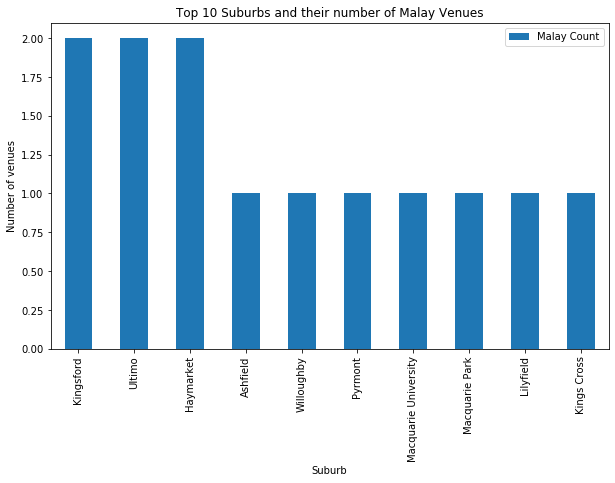

In [50]:
# step 1: get the data
df_malay = top_malay_df.head(10)
df_malay.drop(["Suburb Latitude","Suburb Longitude","Malay Restaurant"],axis=1,inplace=True)
# step 2: plot data
df_malay.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Suburb') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Top 10 Suburbs and their number of Malay Venues') # add title to the plot

plt.show()

#### Find suburbs with Chinese Venues

In [51]:
syd_chinese_venue = sydney_chinese[(sydney_chinese["Chinese Restaurant"]!=0) |
                                   (sydney_chinese["Taiwanese Restaurant"]!=0) |
                                   (sydney_chinese["Dim Sum Restaurant"]!=0) |
                                   (sydney_chinese["Shanghai Restaurant"]!=0) |
                                   (sydney_chinese["Cantonese Restaurant"]!=0) |
                                   (sydney_chinese["Dumpling Restaurant"]!=0)]
syd_chinese_venue.head()

,Suburb,Suburb Latitude,Suburb Longitude,Chinese Restaurant,Szechuan Restaurant,Cantonese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Shanghai Restaurant,Taiwanese Restaurant
92,Ashfield,-33.889478,151.127412,0,0,0,0,0,1,0
93,Ashfield,-33.889478,151.127412,1,0,0,0,0,0,0
94,Ashfield,-33.889478,151.127412,0,0,0,0,1,0,0
95,Ashfield,-33.889478,151.127412,0,0,0,0,0,1,0
99,Ashfield,-33.889478,151.127412,1,0,0,0,0,0,0


In [52]:
syd_chinese_venue["Chinese Count"] = syd_chinese_venue.groupby("Suburb")["Suburb"].transform('size')
syd_chinese_venue.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Suburb,Suburb Latitude,Suburb Longitude,Chinese Restaurant,Szechuan Restaurant,Cantonese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Shanghai Restaurant,Taiwanese Restaurant,Chinese Count
92,Ashfield,-33.889478,151.127412,0,0,0,0,0,1,0,7
93,Ashfield,-33.889478,151.127412,1,0,0,0,0,0,0,7
94,Ashfield,-33.889478,151.127412,0,0,0,0,1,0,0,7
95,Ashfield,-33.889478,151.127412,0,0,0,0,0,1,0,7
99,Ashfield,-33.889478,151.127412,1,0,0,0,0,0,0,7


### Top Suburbs having Chinese Venue

In [53]:
top_chinese = syd_chinese_venue.groupby("Suburb").count()
top_chinese_df = top_chinese.sort_values(by="Chinese Count", ascending=False)
top_chinese_df.head(10)

,Suburb Latitude,Suburb Longitude,Chinese Restaurant,Szechuan Restaurant,Cantonese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Shanghai Restaurant,Taiwanese Restaurant,Chinese Count
Suburb,,,,,,,,,,
Haymarket,9,9,9,9,9,9,9,9,9,9
Eastwood,8,8,8,8,8,8,8,8,8,8
Ashfield,7,7,7,7,7,7,7,7,7,7
Beverly Hills,6,6,6,6,6,6,6,6,6,6
Kingsford,6,6,6,6,6,6,6,6,6,6
Chatswood,5,5,5,5,5,5,5,5,5,5
Ultimo,5,5,5,5,5,5,5,5,5,5
Kings Cross,3,3,3,3,3,3,3,3,3,3
Elizabeth Bay,3,3,3,3,3,3,3,3,3,3


#### Bar Chart of Top 10 Suburbs with Chinese Venues

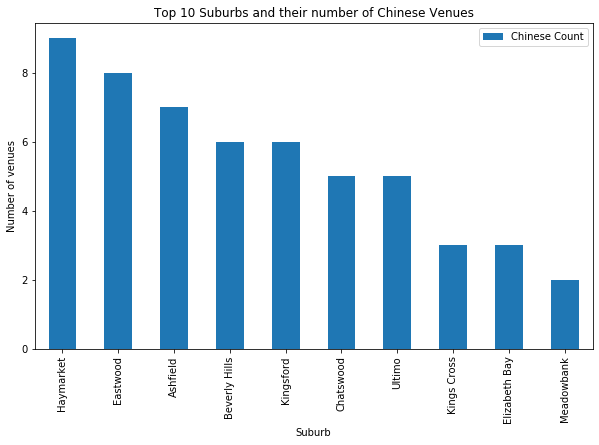

In [54]:
# step 1: get the data
df_chinese = top_chinese_df.head(10)
df_chinese.drop(["Suburb Latitude","Suburb Longitude","Chinese Restaurant",
                 "Szechuan Restaurant","Cantonese Restaurant","Dim Sum Restaurant",
                 "Dumpling Restaurant","Shanghai Restaurant","Taiwanese Restaurant"],axis=1,inplace=True)
# step 2: plot data
df_chinese.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Suburb') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Top 10 Suburbs and their number of Chinese Venues') # add title to the plot

plt.show()

#### Find top suburbs with public transport 

In [55]:
sydney_transport = sydney_onehot[["Suburb","Airport","Bus Station","Bus Stop","Light Rail Station", "Metro Station","Train Station"]]

In [65]:
syd_trans_venue = sydney_transport[(sydney_transport["Airport"]!=0) |
                                   (sydney_transport["Bus Station"]!=0) |
                                   (sydney_transport["Bus Stop"]!=0) |
                                   (sydney_transport["Light Rail Station"]!=0) |
                                   (sydney_transport["Metro Station"]!=0) |
                                   (sydney_transport["Train Station"]!=0)]
syd_trans_venue.head()

,Suburb,Airport,Bus Station,Bus Stop,Light Rail Station,Metro Station,Train Station
28,Ambarvale,0,0,1,0,0,0
108,Ashfield,0,0,0,0,0,1
131,Asquith,0,0,0,0,0,1
234,Balmain,0,1,0,0,0,0
250,Banksia,0,0,0,0,0,1


In [66]:
syd_trans_venue["Transport Count"] = syd_trans_venue.groupby("Suburb")["Suburb"].transform('size')
syd_trans_venue.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Suburb,Airport,Bus Station,Bus Stop,Light Rail Station,Metro Station,Train Station,Transport Count
28,Ambarvale,0,0,1,0,0,0,1
108,Ashfield,0,0,0,0,0,1,1
131,Asquith,0,0,0,0,0,1,1
234,Balmain,0,1,0,0,0,0,1
250,Banksia,0,0,0,0,0,1,1


### Top Suburbs having Public Transport

In [67]:
top_transport = syd_trans_venue.groupby("Suburb").count()
top_transport_df = top_transport.sort_values(by="Transport Count", ascending=False)
top_transport_df.head(10)

,Airport,Bus Station,Bus Stop,Light Rail Station,Metro Station,Train Station,Transport Count
Suburb,,,,,,,
Rozelle,3,3,3,3,3,3,3
Turrella,2,2,2,2,2,2,2
Pennant Hills,2,2,2,2,2,2,2
North Willoughby,2,2,2,2,2,2,2
Valley Heights,2,2,2,2,2,2,2
Frenchs Forest,2,2,2,2,2,2,2
Kellyville,2,2,2,2,2,2,2
Moore Park,2,2,2,2,2,2,2
Waverton,2,2,2,2,2,2,2


#### Bar Chart of Top 10 Suburbs with Public Transport

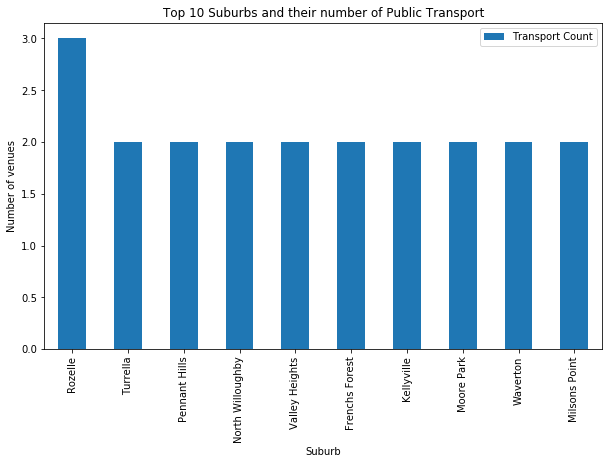

In [68]:
# step 1: get the data
df_transport = top_transport_df.head(10)
df_transport.drop(["Airport","Bus Station","Bus Stop","Light Rail Station","Metro Station","Train Station"],axis=1,inplace=True)
# step 2: plot data
df_transport.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Suburb') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Top 10 Suburbs and their number of Public Transport') # add title to the plot

plt.show()

### Machine Learning : K-Means Clustering
#### K-Means is used to find suburbs which are similar to each other

In [69]:
sydney_grouped = sydney_onehot.groupby("Suburb").mean().reset_index()
sydney_grouped.head(10)

,Suburb,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Carpet Store,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Newsstand,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Fie

In [70]:
# set number of clusters
kclusters = 5
syd_grouped = sydney_grouped
sydney_grouped_clustering = syd_grouped.drop(['Suburb','Suburb Latitude','Suburb Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sydney_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 2, 0, 2, 0, 0, 2, 0, 2], dtype=int32)

In [71]:
sydney_grouped_clustering.head()

,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Carpet Store,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Newsstand,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soci

### Let's Visualize the clusters

In [72]:
# add clustering labels
sydney_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
sydney_grouped.head() 

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_grouped['Suburb Latitude'], sydney_grouped['Suburb Longitude'], sydney_grouped['Suburb'], sydney_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters